# **<center style="color: green;">Desafío - Segmentación de Clientes</center>**

#### **Nombre:** Cristian Tobar Morales ###
#### **Curso:** Machine Learning ###

# **Descripción**
En el apasionante mundo del comercio minorista, el supermercado "FreshMart" se ha
convertido en el lugar preferido para realizar las compras del día a día. Con el objetivo de
brindar una experiencia de compra más personalizada, "FreshMart" ha decidido emplear
técnicas de aprendizaje no supervisado para segmentar a sus clientes y diseñar estrategias
de marketing adaptadas a sus necesidades y preferencias.

Con un amplio conjunto de datos recopilados durante el último año, que incluyen
información de compras y perfiles de clientes, "FreshMart" cuenta con una valiosa fuente de
información para el análisis. Ahora, el desafío radica en aplicar técnicas de clustering
innovadoras para descubrir segmentos de clientes que comparten patrones de compra
similares y comportamientos de consumo.

## objetivo principal de la segmentación de clientes
Identificar grupos específicos dentro
de la base de clientes de "FreshMart" que puedan beneficiarse de promociones y campañas
de marketing personalizadas. La idea es poder caracterizar estos segmentos y ponerle un
nombre a cada uno.

## objetivo final de "FreshMart"
Es mejorar la satisfacción del cliente y optimizar la
rentabilidad del supermercado. Al emplear técnicas de clustering avanzadas y aprovechar
los datos históricos disponibles, "FreshMart" estará en condiciones de ofrecer una
experiencia de compra más personalizada y adaptada a las necesidades de cada segmento
de clientes. Esto consolida la fidelidad de los clientes existentes y atrae a nuevos clientes
que buscan un supermercado que se preocupe por sus preferencias individuales.

## Descripción de los atributos 
La data entregada esta a nivel de boleta y tiene los siguientes campos:
- `InvoiceNo:` Nro identificador de cada boleta
- `InvoiceDate:` Fecha de la boleta
- `CustomerId:` Nro identificador de cada usuario
- `Quantity:` Cantidad de unidades totales compradas
- `price_total:` Precio total de la boleta
- `StockCode:` Cantidad de unidades diferentes compradas

# **Desarrollo**

## Cargar el DataSet y Exploración inicial

### Importar librerías 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Cargar el dataset y exploración

In [2]:
# Cargar el archivo
df = pd.read_excel('Retail_Invoices.xlsx', engine='openpyxl')

# Mostrar el DataSet
df.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [3]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB


Con respecto a la información inicial del dataset se puede concluir:
- La cantidad de columnas: 6
- Cantidad de filas: 22190
- EL tipo de datos corresponde: datetime64(1), float64(1), int64(3), object(1)
- La data no cuenta con valores nulos

### Visualización inicial

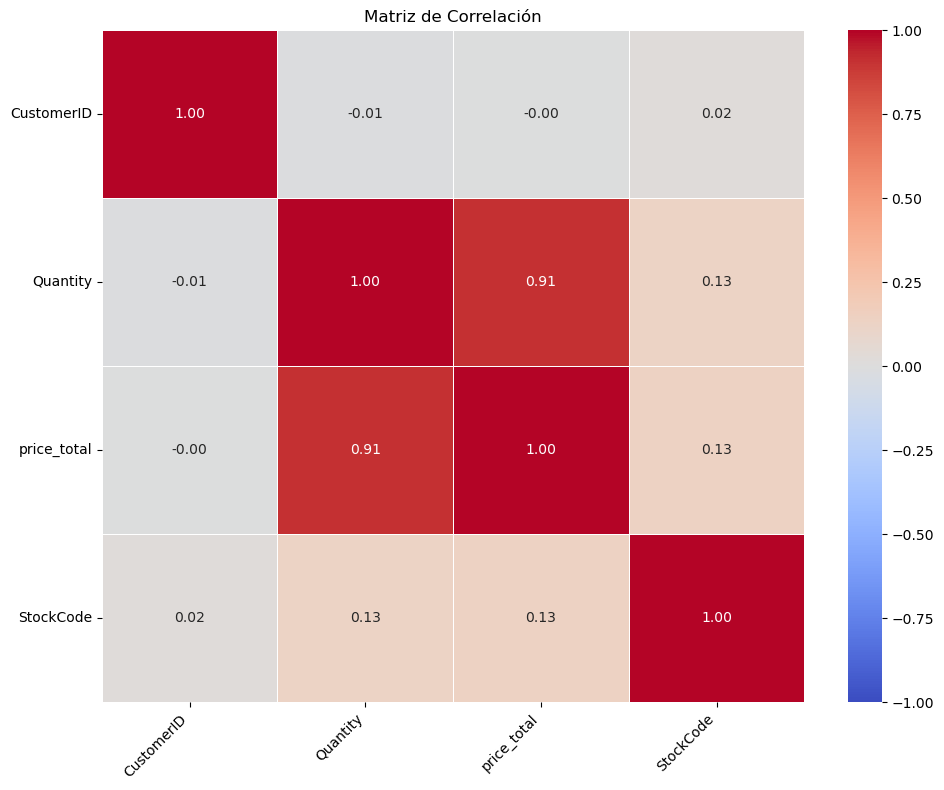

In [4]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), 
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5,
            vmin=-1,
            vmax=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

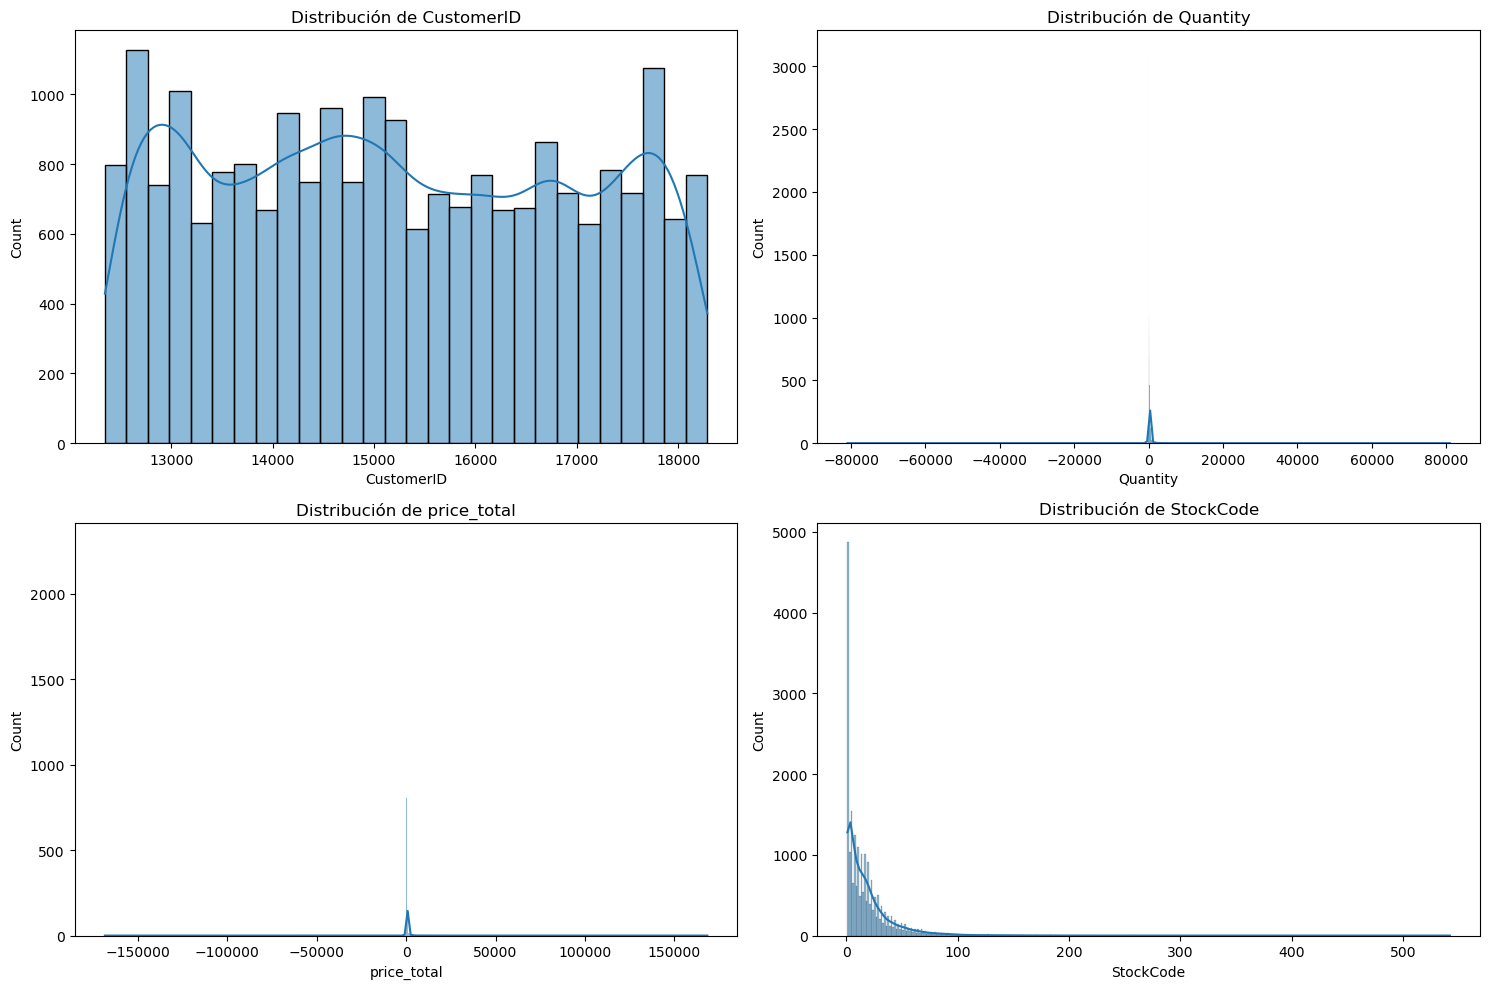

In [5]:
# Distribución de variables numéricas
numeric_columns =['CustomerID', 'Quantity', 'price_total', 'StockCode']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

## Limpieza de datos 
### Valores Atípicos
Podemos graficar todas las columnas numéricas para inspeccionar visualmente los outliers, pero en datasets grandes esto puede no ser práctico.  


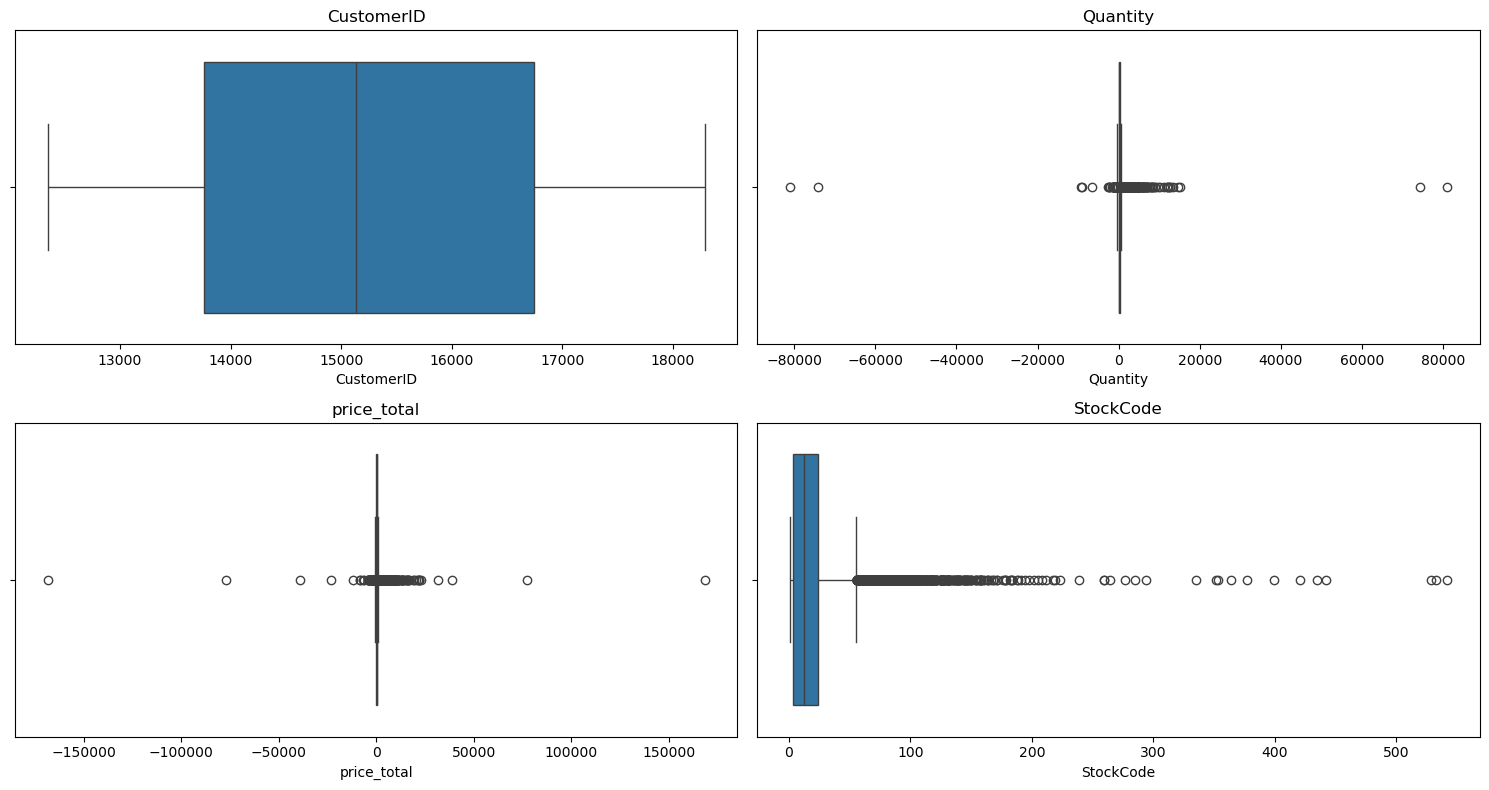

In [6]:
# Creamos un boxplot para cada variables numérica
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

No se implementa tratamiento de valores atípicos en el dataset, debido a que los datos más alejados pueden presentarse como compras exageras o varias cantidades de productos. 

Sin embargo, se pretende eliminar las variables negativas correspondientes a devoluciones de productos, con la finalidad de no interrumpir el análisis de las compras realizadas por los compradores. Las filas con devolución el numero identificador de la boleta comienza con ‘C’. 

In [ ]:
# Eliminar filas con devoluciones
df_sin_devolucion = df[~df['InvoiceNo'].astype(str).str.startswith('C')]   

Observamos las variables con un gráfico de Boxplot.

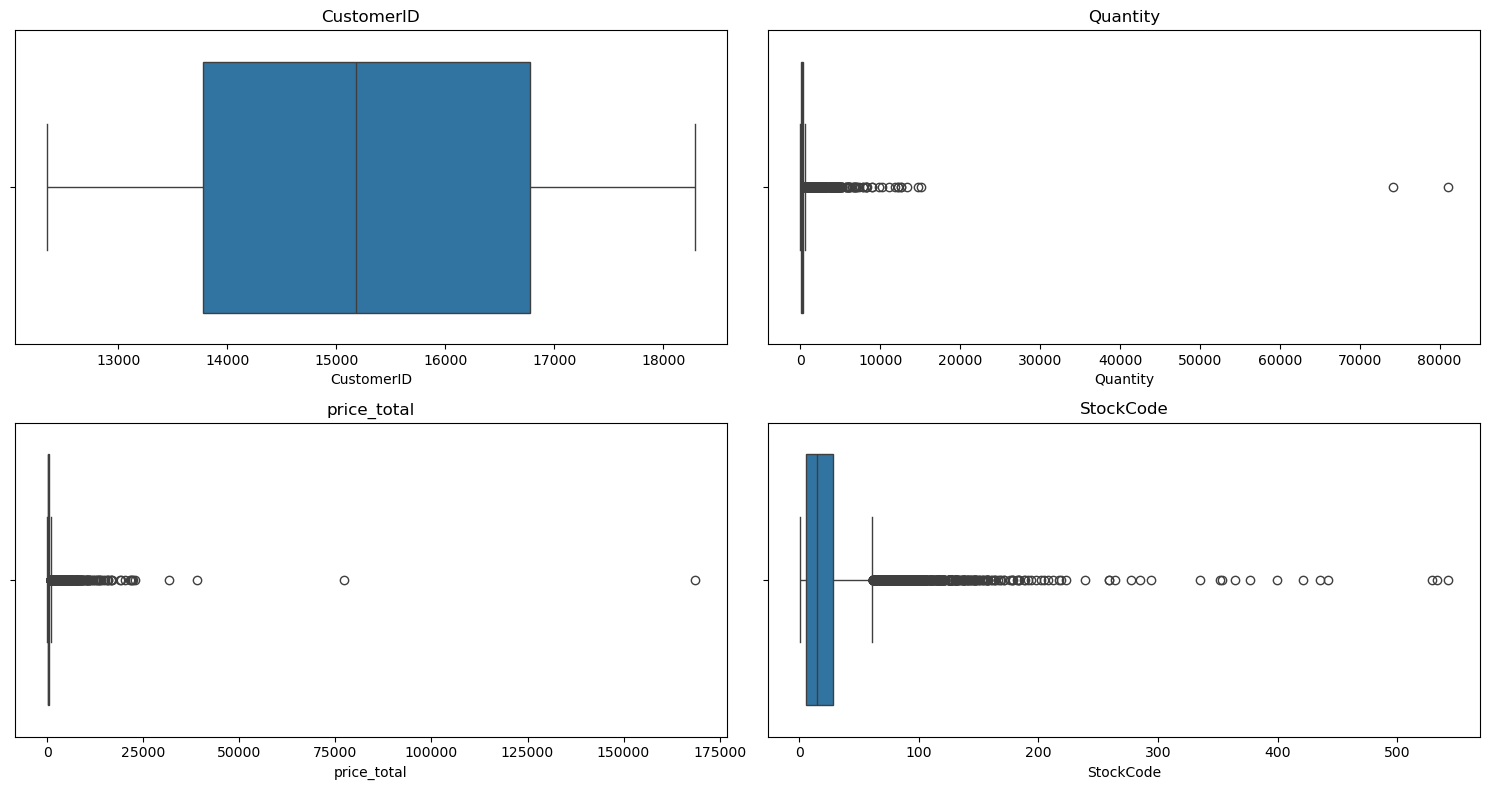

In [9]:
# Creamos un boxplot para cada variables numérica
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_sin_devolucion[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## Generar variables para la segmentación
Notar que la granularidad de la data es por
boleta y se necesita segmentar clientes, por lo que es necesario generar variables a
nivel de clientes. Se propone generar al menos RFM (Recencia, frecuencia y monto).

Realizar un análisis exploratorio y las transformaciones necesarias a las nuevas
variables.


### Recencia, Frecuencia y Monto

In [13]:
df_sin_devolucion.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [ ]:
# Definir fecha de snapshot
'''
Se toma la fecha máxima de las órdenes y se suma el día un días
con la finalidad para tener en cosideración la fecha máxima en el estudio
'''
snapshot_date = df_sin_devolucion['InvoiceDate'].max() + pd.Timedelta(days=1)

# Agregar y calcular RFM
'''
recencia: días desde la última compra
frecuencia: número total de órdenes
monto: gasto acumulado
'''
rfm = (df_sin_devolucion.groupby('CustomerID').agg(
    recencia = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    frecuencia = ('InvoiceDate', 'count'),
    monto = ('price_total', 'sum')
).reset_index())

# Imprimir data
rfm.head()

,CustomerID,recencia,frecuencia,monto
0,12346,326,1,77183.60
1,12347,3,7,4310.00
2,12348,76,4,1797.24
3,12349,19,1,1757.55
4,12350,311,1,334.40


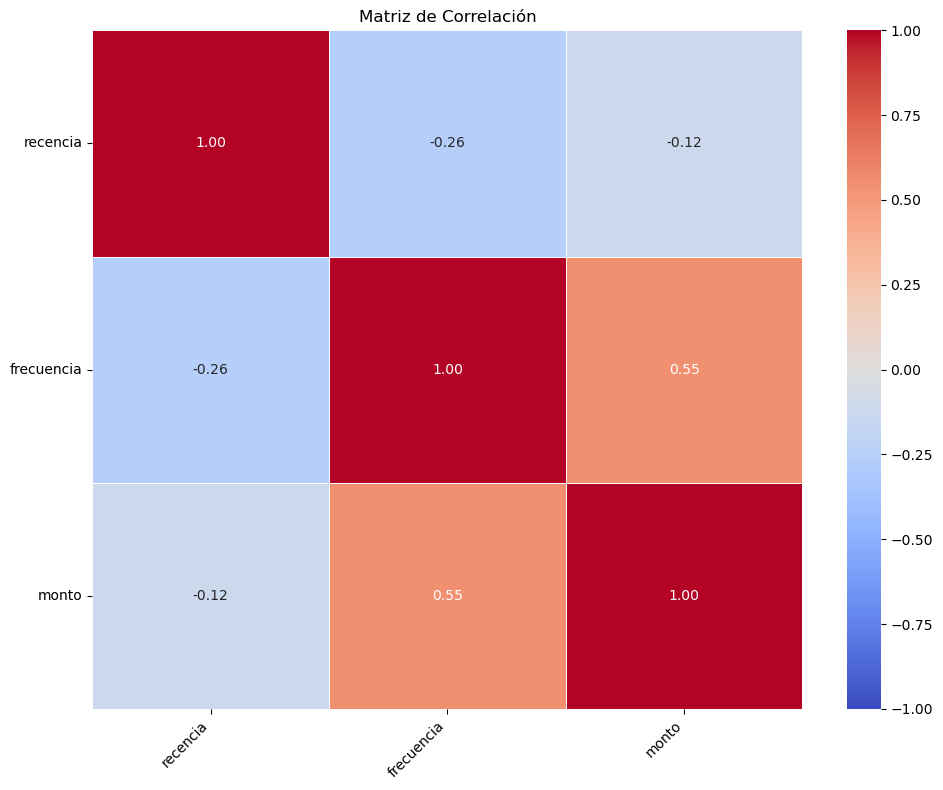

In [27]:
# Matriz de correlación
columnas = ['recencia', 'frecuencia', 'monto']

def matrizCorrelacion(columnas):
    plt.figure(figsize=(10, 8))
    sns.heatmap(rfm[columnas].corr(numeric_only=True), 
                annot=True,
                fmt=".2f",
                cmap="coolwarm",
                linewidths=0.5,
                vmin=-1,
                vmax=1)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title("Matriz de Correlación")
    plt.tight_layout()
    plt.show()

matrizCorrelacion(columnas)

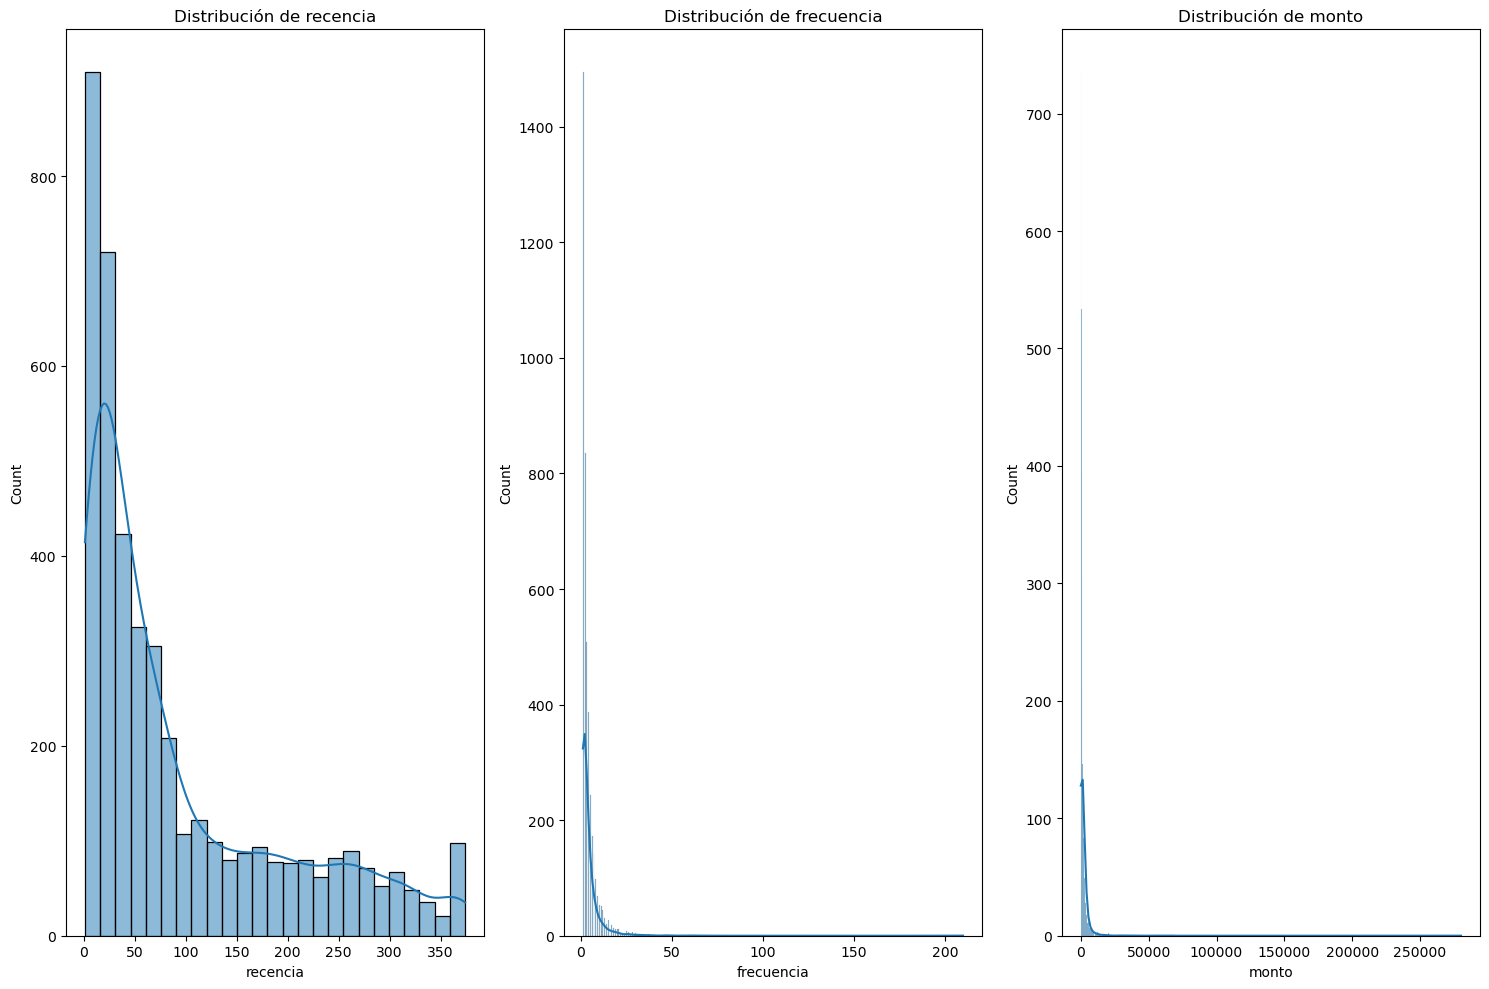

In [21]:
# Distribución de variables numéricas
plt.figure(figsize=(15, 10))
for i, col in enumerate(columnas, 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm[col].dropna(), kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

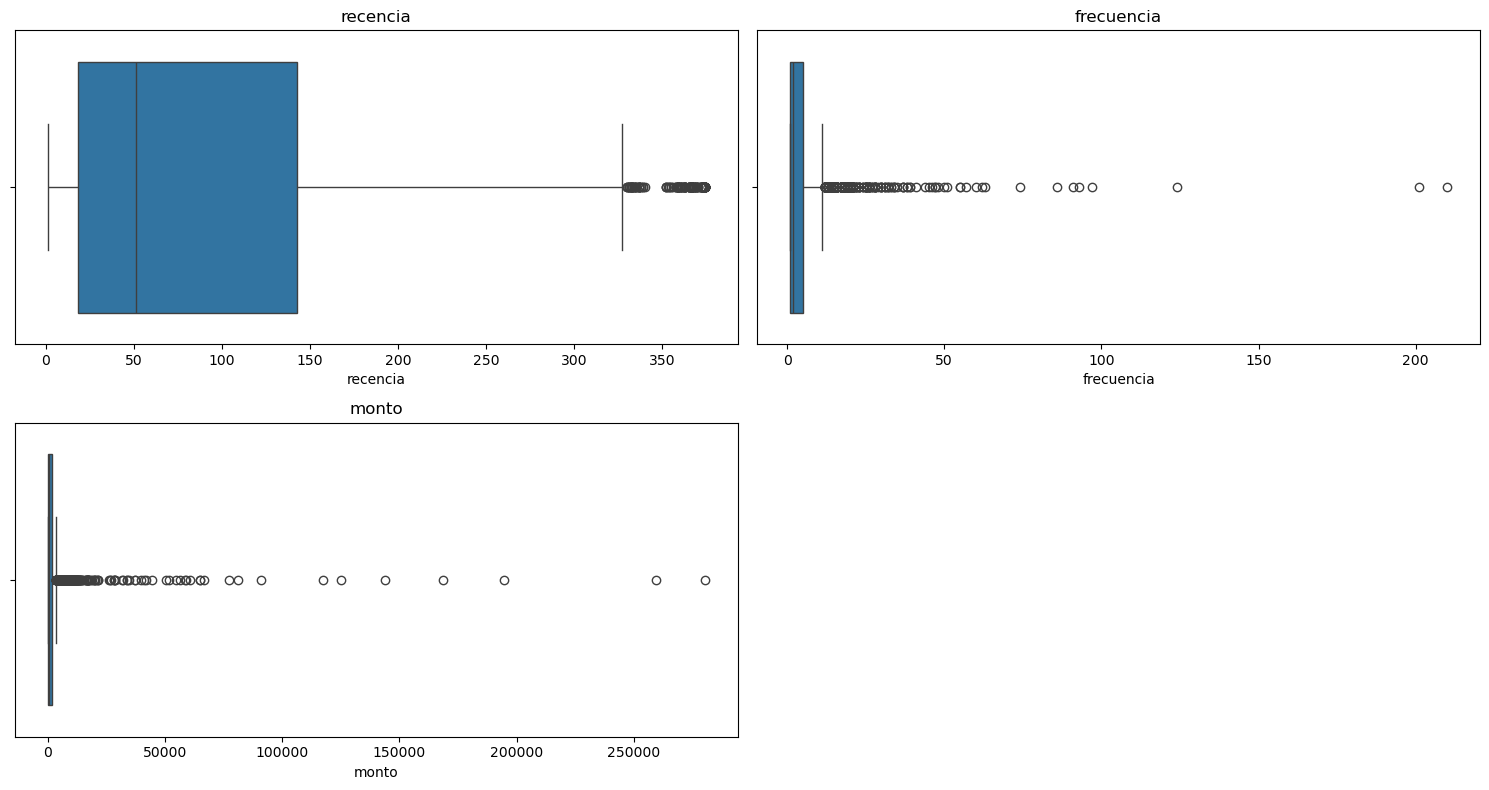

In [30]:
# Boxplot para cada variables numérica
def graficoBoxplot(columnas):
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(columnas, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x=rfm[col])
        plt.title(col)

    plt.tight_layout()
    plt.show()

graficoBoxplot(columnas)

No se pretende eliminar o reemplazar los valores atípicos por la media o mediana, simplemente se realizará una transformación logarítmica. 

### Transformación logarítmica para monto y frecuencia
Aplicar una transformación logarítmica aporta varios beneficios clave, que suelen presentar distribuciones muy segadas y valores extremos.
- Facilita el análisis de datos sesgados, las compras de unos pocos clientes suelen ser muy altas. El logaritmo `comprime` los valores grandes y expande los pequeños, acecando la distribución a una forma más simétrica.

- Mitigar el impacto de outliers, al reducir la distancia relativa entre valores extremos y la mayoría de los datos.

In [24]:
# Transformación logarítmica
rfm['frecuencia_log'] = np.log1p(rfm['frecuencia'])
rfm['monto_log'] = np.log1p(rfm['monto'])

### Escalado

In [ ]:
# Selección de nuevas variables númericas
features = rfm[['recencia', 'frecuencia_log', 'monto_log']]

# Escalado
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(features)

# Lo convertimos en DataFrame con nombres de columnas
df_escalado = pd.DataFrame(datos_escalados, columns=features.columns)

# Mostramos las primeras filas escaladas
df_escalado.head()

,recencia,frecuencia_log,monto_log
0,2.329673,-0.955013,3.696168
1,-0.900449,1.074523,1.408758
2,-0.170421,0.386437,0.715517
3,-0.740443,-0.955013,0.697821
4,2.179667,-0.955013,-0.615877


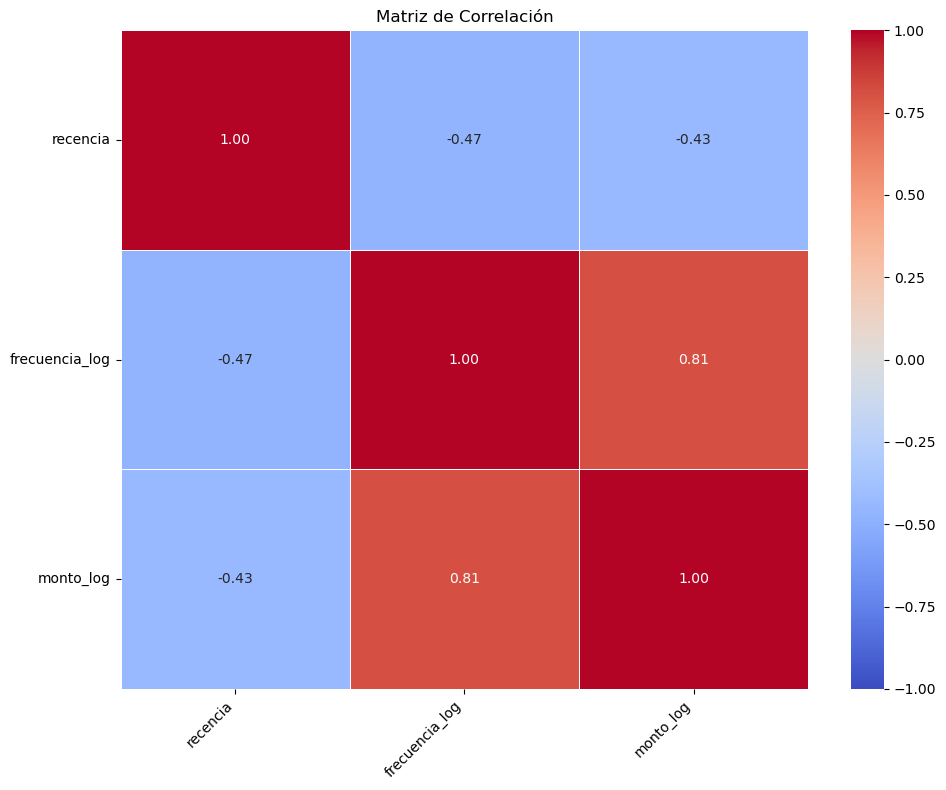

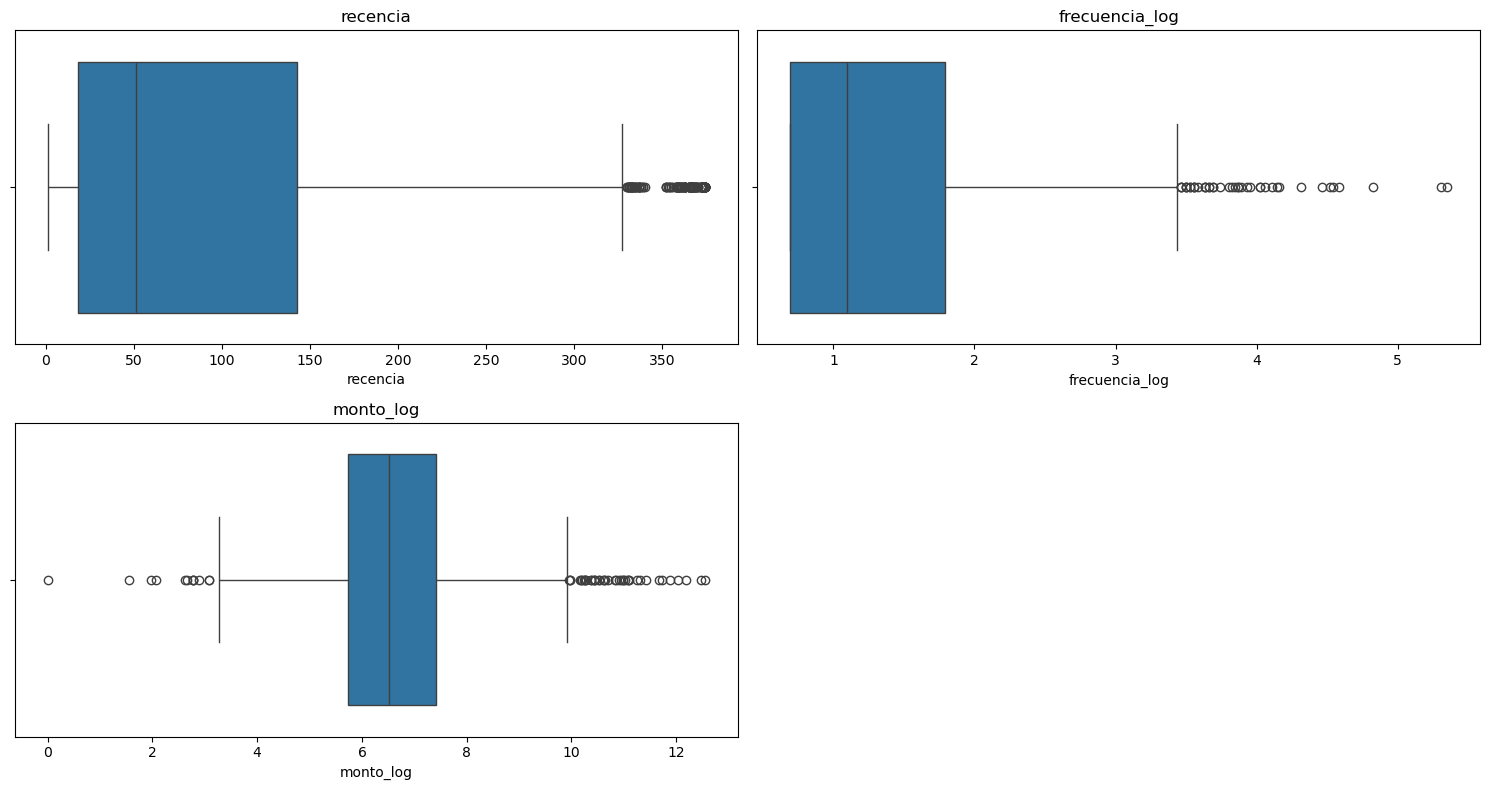

In [31]:
# Matriz de correlación
matrizCorrelacion(df_escalado.columns)

# Boxplot
graficoBoxplot(df_escalado.columns)

## Análisis de Componentes Principales (PCA)
El Análisis de Componentes Principales (PCA) es una técnica estadística que permite reducir la cantidad de variables de un conjunto de datos, conservando la mayor parte de su variabilidad. Es especialmente útil cuando se trabaja con muchas variables que están correlacionadas entre sí.

Nuestro objetivo es usar PCA para resumir esta información en solo dos variables (componentes principales), que puedan ser visualizadas y analizadas más fácilmente.

In [32]:
from sklearn.decomposition import PCA

# Aplicamos PCA a los datos
pca = PCA(n_components= 2, random_state= 42)
X_pca = pca.fit_transform(datos_escalados)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca

,PC1,PC2
0,0.548035,3.149532
1,1.970757,0.073896
2,0.762878,0.239952
3,0.190650,-0.671951
4,-2.027595,1.381369
...,...,...
4334,-2.166809,0.908278
4335,-2.086139,-0.179485
4336,-0.498240,-1.275660
4337,2.303216,0.200370


Podemos observar cuánta varianza explican los dos primeros componentes. Esto nos dirá, por ejemplo, si con solo dos componentes estamos explicando el 90% de la información del dataset.

In [33]:
# Mostrar varianza explicada
print("Varianza explicada por PCA:", pca.explained_variance_ratio_)

Varianza explicada por PCA: [0.72010882 0.21592419]


En conjunto, con dos componentes retienen aproximadamente el 93.6 % de la información original.

## Algoritmos de clustering

### K-Means
K-Means es uno de los algoritmos más conocidos para agrupar datos automáticamente. Su objetivo es descubrir grupos ocultos en los datos, sin necesidad de etiquetas previas.

El **método del codo** es una técnica visual utilizada para **determinar el número óptimo de clusters**.

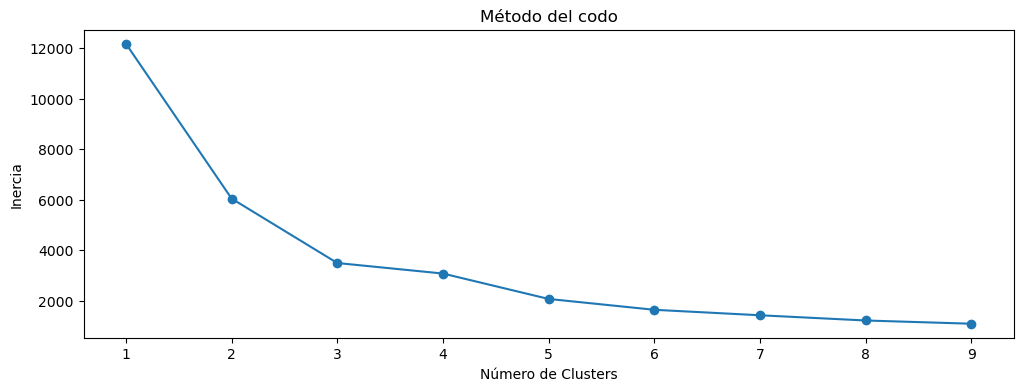

In [36]:
# Determinar el número de cluster
inercia = []
range_k = range(1, 10)
for k in range_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inercia.append(km.inertia_)

# Graficar el método del codo para KMeans
plt.figure(figsize=(12, 4))
plt.plot(range_k, inercia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

La gráfica del método del codo muestra un codo pronunciado k=3, lo que sugiere 3 clusters es un buen compromiso entre complejidad y varianza explicada. 

In [38]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [39]:
# KMeans K= 3
kmeans = KMeans(n_clusters=3, random_state=42)
label_kmeans = kmeans.fit_predict(X_pca)

# Métricas
silhouette_kmeans = silhouette_score(X_pca, label_kmeans)
davies_kmeans = davies_bouldin_score(X_pca, label_kmeans)
calinski_kmeans = calinski_harabasz_score(X_pca, label_kmeans)

### Clustering jerárquico
Es una técnica que **organiza los datos en una estructura en forma de árbol**, mostrando cómo se agrupan paso a paso según su similitud. A diferencia de K-Means, **no requiere definir el número de clusters de antemano**. En lugar de optimizar una función única, este método **sigue un procedimiento secuencial**, guiado por un criterio de distancia entre grupos.

In [45]:
# k= 3
hier = AgglomerativeClustering(n_clusters=3)
labels_hier = hier.fit_predict(X_pca)

# Métricas
silhouette_hier = silhouette_score(X_pca, labels_hier)
davies_hier = davies_bouldin_score(X_pca, labels_hier)
calinski_hier = calinski_harabasz_score(X_pca, labels_hier)

### DBSCAN
Es un algoritmo de clustering que agrupa puntos **según la densidad del entorno en el que se encuentran**. A diferencia de K-Means o el clustering jerárquico, **no necesita saber cuántos clusters hay**.

La idea principal es que los puntos en regiones densamente pobladas deben formar un grupo, mientras que los puntos aislados (con pocos vecinos cercanos) se consideran **ruido** o **outliers**.

In [46]:
db = DBSCAN(eps= 0.5, min_samples= 5)
label_dbscan= db.fit_predict(X_pca)

# Métricas
silhouette_db = silhouette_score(X_pca, label_dbscan)
davies_db = davies_bouldin_score(X_pca, label_dbscan)
calinski_db = calinski_harabasz_score(X_pca, label_dbscan)

## Visualización

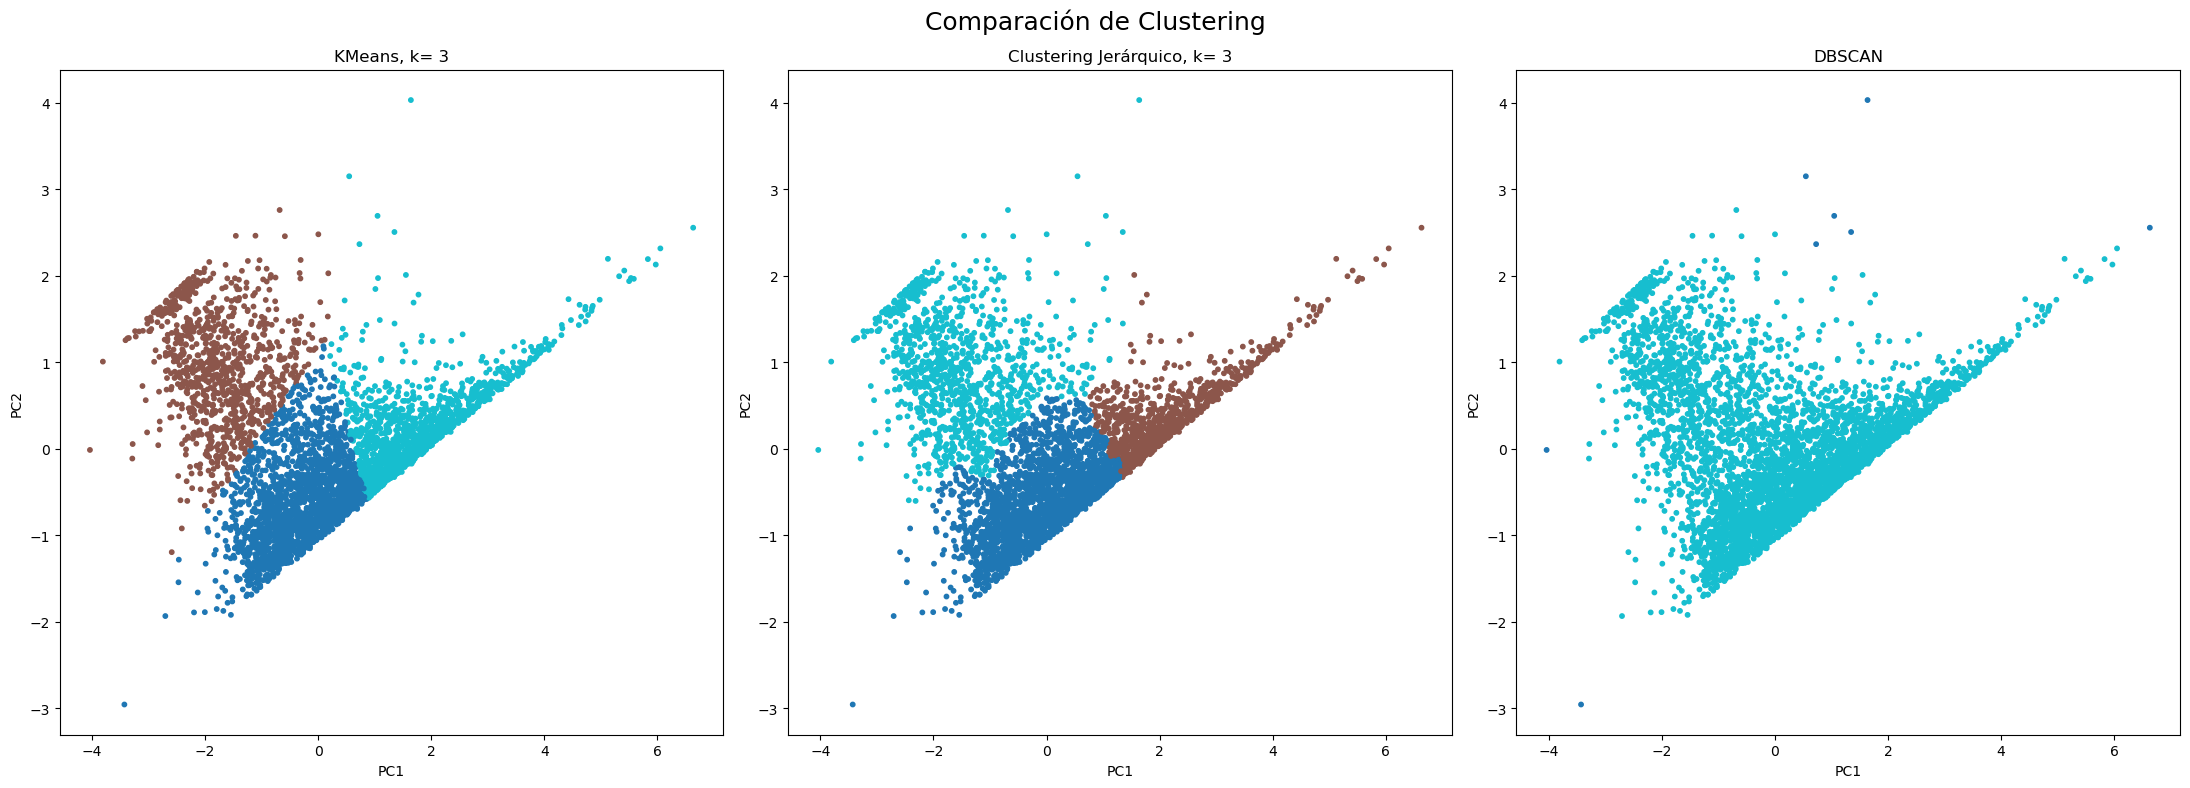

In [54]:
# Visualización de los 3 clustering
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=label_kmeans, cmap='tab10', s=10)
axes[0].set_title('KMeans, k= 3')
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_hier, cmap='tab10', s=10)
axes[1].set_title('Clustering Jerárquico, k= 3')
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=label_dbscan, cmap='tab10', s=10)
axes[2].set_title('DBSCAN')
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")

plt.suptitle('Comparación de Clustering', fontsize=18)
plt.tight_layout()
plt.show()


C:\Users\crist\AppData\Local\Temp\ipykernel_12908\102025134.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=score, ax=ax,  palette="pastel")
C:\Users\crist\AppData\Local\Temp\ipykernel_12908\102025134.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=score, ax=ax,  palette="pastel")
C:\Users\crist\AppData\Local\Temp\ipykernel_12908\102025134.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=score, ax=ax,  palette="pastel")


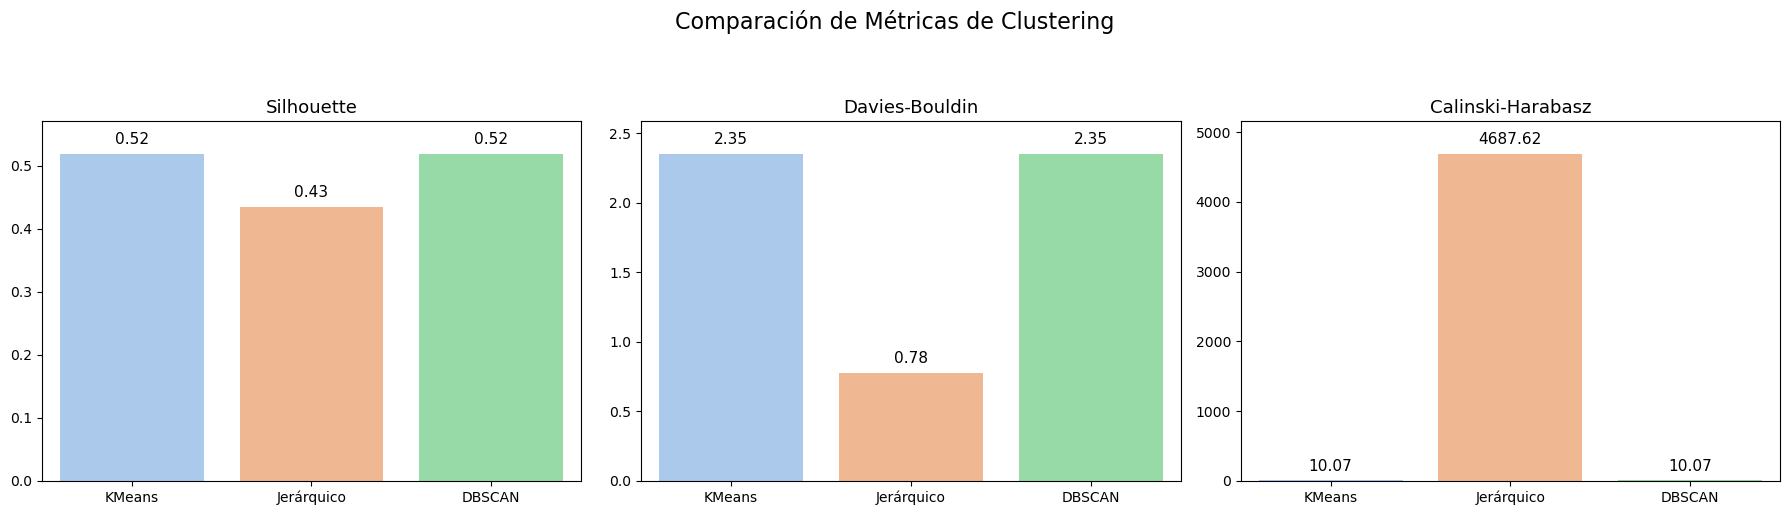

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficaComparativa(scores, 
                       metric_names=['Silhouette','Davies-Bouldin','Calinski-Harabasz'],
                       labels=['KMeans','Jerárquico','DBSCAN']):
    """
    Dibuja 3 barplots con las 3 métricas de clustering.
    - scores: lista de 3 listas, cada lista tiene 3 valores [KMeans, Hier, DBSCAN]
    - metric_names: nombres para cada subplot
    - labels: etiquetas de los algoritmos
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, score, name in zip(axes, scores, metric_names):
        sns.barplot(x=labels, y=score, ax=ax,  palette="pastel")
        ax.set_title(name, fontsize=13)
        ax.set_ylim(0, max(score) * 1.1)
        for i, v in enumerate(score):
            ax.text(i, v + max(score)*0.02, f"{v:.2f}", 
                    ha='center', va='bottom', fontsize=11)
    plt.suptitle('Comparación de Métricas de Clustering', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Tus scores preparados:
scores = [
    [silhouette_kmeans, silhouette_hier, silhouette_db],
    [davies_kmeans,    davies_hier,    davies_db],
    [calinski_kmeans,  calinski_hier,  calinski_db]
]

# Una sola llamada:
graficaComparativa(scores)
